In [ ]:
!pip install pyJoules[nvidia]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install keras_flops

In [ ]:
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
from datetime import datetime
from keras_flops import get_flops
from pyJoules.energy_meter import measure_energy
import pandas as pd
import numpy as np
import random
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
# Carregando os dados
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Dividindo o conjunto de treinamento em treinamento e validação
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

# Pré-processando os dados
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')
x_valid = x_valid.reshape(-1, 28, 28, 1).astype('float32')

x_train /= 255
x_test /= 255
x_valid /= 255

n_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, n_classes)

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 64)                589888    
                                                        

In [ ]:
models = []
val_accuracies = []
accuracies = []

for i in range(10):
  print('-------------------------------------------------------------')
  print('modelo ' + str(i+1))
  tempo1 = datetime.now()

  @measure_energy
  def foo():
   return model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, validation_data=(x_valid, y_valid))

  history = foo()

  tempo2 = datetime.now()

  print(f"O tempo de treino em (hh:mm:ss.ms) foi {tempo2-tempo1}")

  media_acc =  np.mean(history.history['accuracy'])
  media_acc_val = np.mean(history.history['val_accuracy'])
  val_accuracies.append(media_acc_val)
  accuracies.append(media_acc_val)
  print(f'Média das acurácias: {media_acc}')
  print(f'Média das acurácias(val): {media_acc_val}')


  flops = get_flops(model, batch_size=128)
  print(f"FLOPS: {flops / 10 ** 9:.03} G")

# Evaluate the model
  val_loss, val_accuracy = model.evaluate(x_valid, y_valid, verbose=0)

 # Store the model and its accuracy
  models.append(model)
  val_accuracies.append(media_acc_val)

mean_accuracy_val = np.mean(val_accuracies)
print(f'Média da Acurácia geral: {mean_accuracy_val}')

# Select the model with the highest accuracy
best_model_index = accuracies.index(max(accuracies))
best_model = models[best_model_index]
print('***********************************')
print('O modelo escolhido para inferência foi o modelo: ' + str(best_model_index+1))

# Use the best model for inference
tempo3 = datetime.now()
y_pred = best_model.predict(x_test)
tempo4 = datetime.now()
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

acuracia = accuracy_score(y_test_classes, y_pred_classes)
precisao = precision_score(y_test_classes, y_pred_classes, average='macro')
recal = recall_score(y_test_classes, y_pred_classes, average='macro')
f1 = f1_score(y_test_classes, y_pred_classes, average='macro')

print(f'Acurácia: {acuracia}')
print(f'Precisão: {precisao}')
print(f'Recall: {recal}')
print(f'F1-Score: {f1}')

print(f"O tempo de inferência em (hh:mm:ss.ms) foi {tempo4-tempo3}")

-------------------------------------------------------------
modelo 1
Epoch 1/20
375/375 [==============================] - 13s 5ms/step - loss: 0.3712 - accuracy: 0.8871 - val_loss: 0.0923 - val_accuracy: 0.9728
Epoch 2/20
375/375 [==============================] - 2s 4ms/step - loss: 0.1443 - accuracy: 0.9591 - val_loss: 0.0735 - val_accuracy: 0.9779
Epoch 3/20
375/375 [==============================] - 2s 4ms/step - loss: 0.1110 - accuracy: 0.9675 - val_loss: 0.0519 - val_accuracy: 0.9854
Epoch 4/20
375/375 [==============================] - 2s 4ms/step - loss: 0.0877 - accuracy: 0.9743 - val_loss: 0.0494 - val_accuracy: 0.9858
Epoch 5/20
375/375 [==============================] - 2s 4ms/step - loss: 0.0759 - accuracy: 0.9772 - val_loss: 0.0464 - val_accuracy: 0.9867
Epoch 6/20
375/375 [==============================] - 2s 4ms/step - loss: 0.0684 - accuracy: 0.9790 - val_loss: 0.0482 - val_accuracy: 0.9863
Epoch 7/20
375/375 [==============================] - 2s 4ms/step - loss: 0.

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


begin timestamp : 1692895567.0945435; tag : foo; duration : 44.07680892944336; nvidia_gpu_0 : 4436211
O tempo de treino em (hh:mm:ss.ms) foi 0:00:44.090833
Média das acurácias: 0.97793750166893
Média das acurácias(val): 0.9872583359479904
FLOPS: 2.93 G
-------------------------------------------------------------
modelo 2
Epoch 1/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0270 - accuracy: 0.9906 - val_loss: 0.0478 - val_accuracy: 0.9898
Epoch 2/20
375/375 [==============================] - 2s 4ms/step - loss: 0.0250 - accuracy: 0.9916 - val_loss: 0.0495 - val_accuracy: 0.9902
Epoch 3/20
375/375 [==============================] - 2s 4ms/step - loss: 0.0262 - accuracy: 0.9909 - val_loss: 0.0505 - val_accuracy: 0.9901
Epoch 4/20
375/375 [==============================] - 2s 4ms/step - loss: 0.0242 - accuracy: 0.9918 - val_loss: 0.0548 - val_accuracy: 0.9898
Epoch 5/20
375/375 [==============================] - 2s 4ms/step - loss: 0.0249 - accuracy: 0.9916 - val_lo

In [ ]:
cm = confusion_matrix(y_test_classes, y_pred_classes)

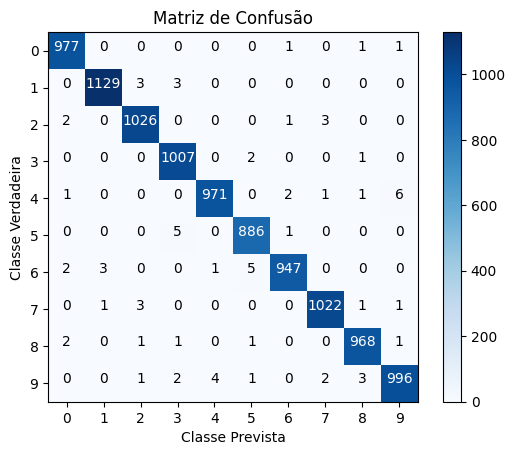

In [ ]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()